In [1]:
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
from pathlib import Path

env_path = Path('../env')
load_dotenv(dotenv_path=env_path)

DB_TORONTO_TRAFFIC_COLLISIONS_ALL = os.getenv('DB_TORONTO_TRAFFIC_COLLISIONS_ALL')

engine = create_engine(DB_TORONTO_TRAFFIC_COLLISIONS_ALL)

Exploratory data analysis

1. Summary Statistics

array([[<AxesSubplot:title={'center':'_id'}>,
        <AxesSubplot:title={'center':'OCC_DATE'}>,
        <AxesSubplot:title={'center':'OCC_YEAR'}>,
        <AxesSubplot:title={'center':'OCC_HOUR'}>],
       [<AxesSubplot:title={'center':'FATALITIES'}>,
        <AxesSubplot:title={'center':'INJURY_COLLISIONS'}>,
        <AxesSubplot:title={'center':'FTR_COLLISIONS'}>,
        <AxesSubplot:title={'center':'PD_COLLISIONS'}>],
       [<AxesSubplot:title={'center':'LONG_WGS84'}>,
        <AxesSubplot:title={'center':'LAT_WGS84'}>,
        <AxesSubplot:title={'center':'AUTOMOBILE'}>,
        <AxesSubplot:title={'center':'MOTORCYCLE'}>],
       [<AxesSubplot:title={'center':'PASSENGER'}>,
        <AxesSubplot:title={'center':'BICYCLE'}>,
        <AxesSubplot:title={'center':'PEDESTRIAN'}>,
        <AxesSubplot:title={'center':'has_valid_location'}>],
       [<AxesSubplot:title={'center':'OCC_DOM'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

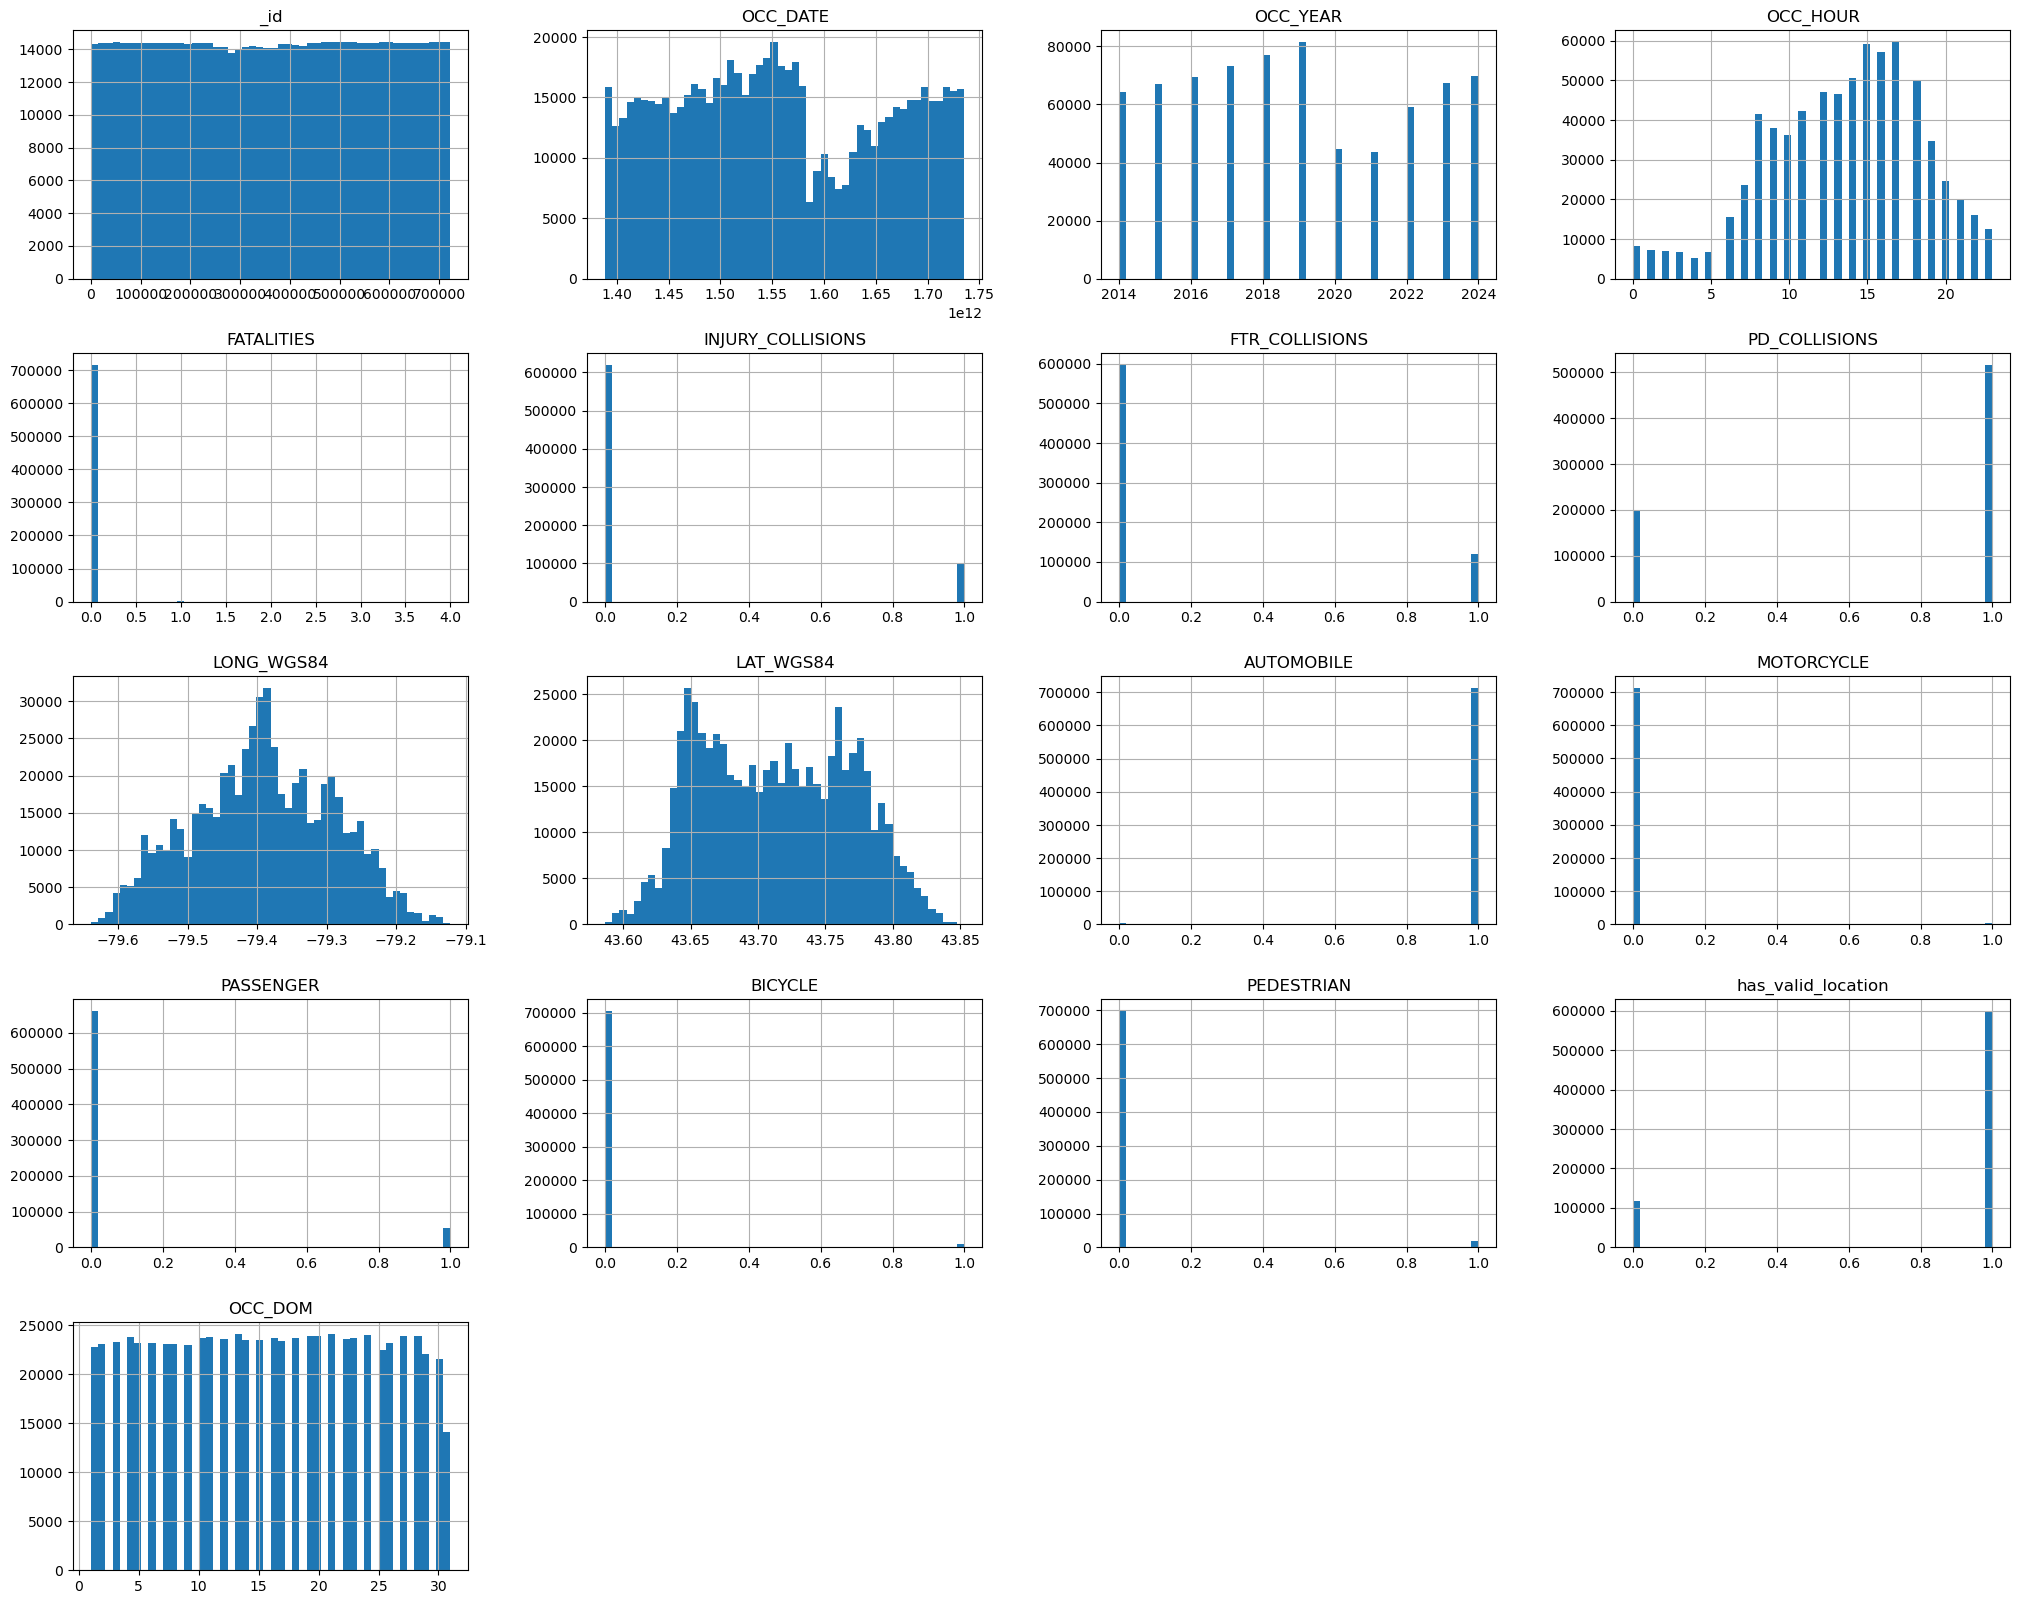

In [ ]:
# get the summary histogram plot
query_1 = "SELECT * FROM collisions"
gdf_all = gpd.read_postgis(query_1, engine, geom_col="geometry")
gdf_all.hist(bins=50, figsize=(25, 20))

2. Investiagte the peak hour of collision of the day in each day of the week


In [28]:
query_2 = """
SELECT "OCC_DOW", "OCC_HOUR", COUNT(*)
FROM collisions
GROUP BY "OCC_DOW", "OCC_HOUR"
ORDER BY (CASE
    WHEN "OCC_DOW"='Monday' THEN 1
    WHEN "OCC_DOW"='Tuesday' THEN 2
    WHEN "OCC_DOW"='Wednesday' THEN 3
    WHEN "OCC_DOW"='Thursday' THEN 4
    WHEN "OCC_DOW"='Friday' THEN 5
    WHEN "OCC_DOW"='Saturday' THEN 6
    ELSE 7
    END), "OCC_HOUR"
"""
df_day_hour = pd.read_sql_query(query_2, engine)
df_day_hour


,OCC_DOW,OCC_HOUR,count
0,Monday,0,1007
1,Monday,1,850
2,Monday,2,777
3,Monday,3,831
4,Monday,4,703
...,...,...,...
163,Sunday,19,3628
164,Sunday,20,3007
165,Sunday,21,2419
166,Sunday,22,1938


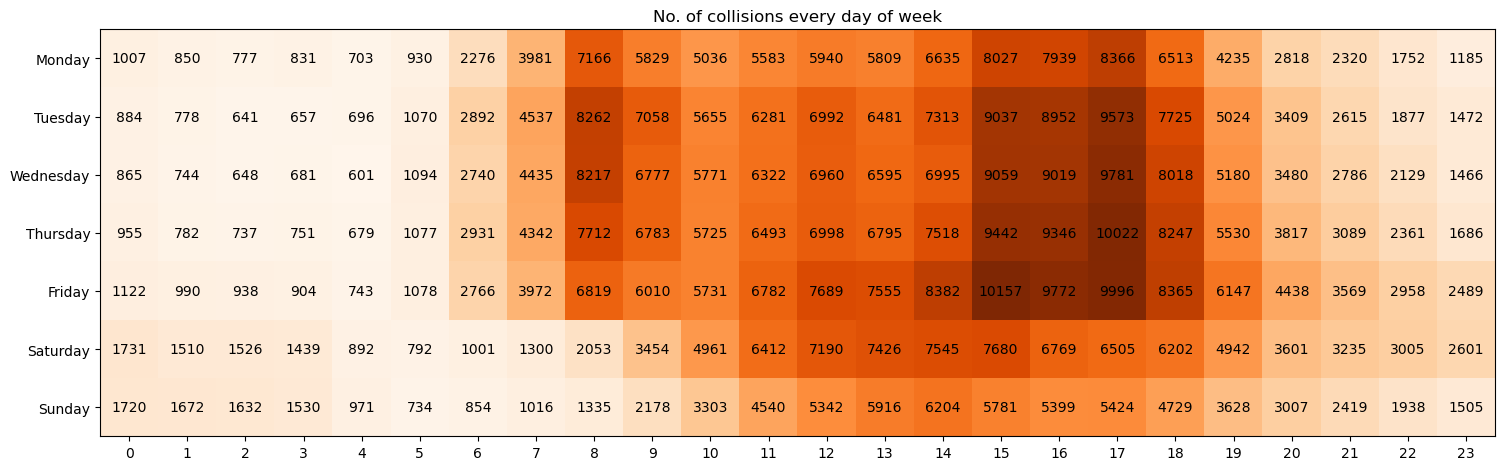

In [50]:
# turn count into 2d matrix
count = df_day_hour['count']

# data
day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data = []
for i in range(7):
    row = []
    for j in range(24):
        row.append(count.iloc[i *24 + j])
    data.append(row)

fig, ax = plt.subplots(figsize=(18,8))
im = ax.imshow(data, cmap="Oranges")

# set title
ax.set_title("No. of collisions every day of week")

# label the axis
ax.set_xticks(range(24))
ax.set_yticks(range(len(day_of_week)), labels=day_of_week)

# text annotations
for i in range(7):
    for j in range(24):
        text = ax.text(j, i, data[i][j],
                       ha="center", va="center")

# set size


plt.show()
